# Define the system  

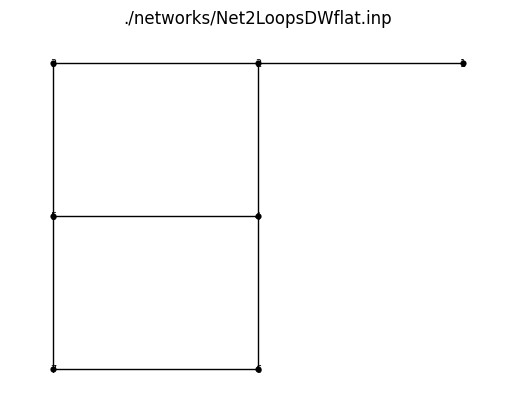

<Axes: title={'center': './networks/Net2LoopsDWflat.inp'}>

In [17]:
import wntr
import wntr_quantum
import numpy as np

# Create a water network model
# inp_file = './networks/Net0.inp'
inp_file = './networks/Net2LoopsDWflat.inp'
# inp_file = './networks/Net2LoopsDW.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# Graph the network
wntr.graphics.plot_network(wn, title=wn.name, node_labels=True)


## Run with the original Cholesky EPANET simulator

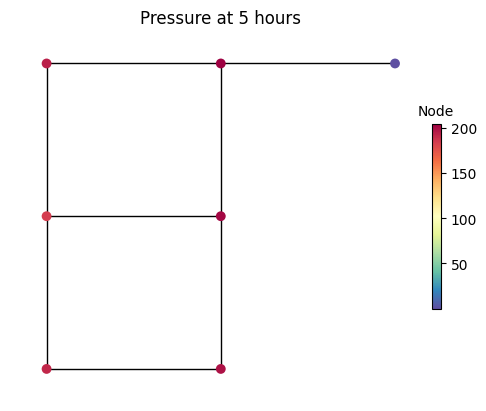

<Axes: title={'center': 'Pressure at 5 hours'}>

In [18]:
sim = wntr.sim.EpanetSimulator(wn)
results = sim.run_sim()
# Plot results on the network
pressure_at_5hr = results.node['pressure'].loc[0, :]
wntr.graphics.plot_network(wn, node_attribute=pressure_at_5hr, node_size=50,
                        title='Pressure at 5 hours', node_labels=False)

In [19]:
ref_pressure = results.node['pressure'].values[0]
ref_pressure

array([2.045e+02, 1.940e+02, 2.013e+02, 1.841e+02, 1.982e+02, 1.912e+02, 4.395e-07], dtype=float32)

In [20]:
ref_rate = results.link['flowrate'].values[0]
ref_rate

array([ 0.311,  0.051,  0.232,  0.032,  0.167,  0.075,  0.024, -0.02 ], dtype=float32)

In [21]:
ref_values = np.append(ref_rate, ref_pressure)
ref_values

array([ 3.111e-01,  5.137e-02,  2.319e-01,  3.161e-02,  1.670e-01,  7.534e-02,  2.360e-02, -1.979e-02,  2.045e+02,  1.940e+02,  2.013e+02,  1.841e+02,  1.982e+02,  1.912e+02,  4.395e-07], dtype=float32)

## Run with the QUBO Polynomial Solver

In [22]:
wn = wntr.network.WaterNetworkModel(inp_file)

In [23]:
from wntr_quantum.sim.solvers.qubo_polynomial_solver import QuboPolynomialSolver
from qubops.solution_vector import SolutionVector_V2 as SolutionVector
from qubops.encodings import  RangedEfficientEncoding, PositiveQbitEncoding

nqbit = 5
step = (15/(2**nqbit-1))
flow_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+0., var_base_name="x")

nqbit = 5
step = (500/(2**nqbit-1))
head_encoding = PositiveQbitEncoding(nqbit=nqbit, step=step, offset=+500.0, var_base_name="x")

net = QuboPolynomialSolver(wn, flow_encoding=flow_encoding, 
              head_encoding=head_encoding)
net.verify_encoding()

Head Encoding : 500.000000 => 1000.000000 (res: 16.129032)
Flow Encoding : -15.000000 => -0.000000 | 0.000000 => 15.000000 (res: 0.483871)


Solve the system classically

In [24]:
from wntr_quantum.sim.qubo_hydraulics import create_hydraulic_model_for_qubo
model, model_updater = create_hydraulic_model_for_qubo(wn)
net.create_index_mapping(model)
net.matrices = net.initialize_matrices(model)

ref_sol, encoded_ref_sol, cvgd = net.classical_solutions()
ref_sol / ref_values[:-1]

/home/nico/QuantumApplicationLab/QuantumNewtonRaphson/quantum_newton_raphson/utils.py:74: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn("spsolve requires A be CSC or CSR matrix format", SparseEfficiencyWarning)


array([1.   , 1.01 , 0.998, 1.019, 0.993, 0.985, 1.021, 0.945, 1.001, 0.999, 1.001, 0.998, 1.001, 1.002])

[]

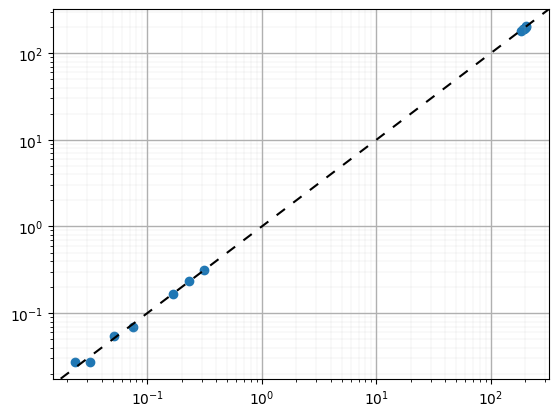

In [27]:
import matplotlib.pyplot as plt 
plt.scatter(ref_values[:-1], encoded_ref_sol)
plt.axline((0, 0.0), slope=1, color="black", linestyle=(0, (5, 5)))
plt.grid(which="major", lw=1)
plt.grid(which="minor", lw=0.1)
plt.loglog()

In [36]:
from wntr_quantum.sim.qubo_hydraulics import create_hydraulic_model_for_qubo
from dwave.samplers import SimulatedAnnealingSampler, TabuSampler, SteepestDescentSampler

sampler = SimulatedAnnealingSampler()
# sampler = TabuSampler()
# sampler = SteepestDescentSampler()
model, model_updater = create_hydraulic_model_for_qubo(wn)
net.solve(model, strength=1E7, sampler=sampler, beta_range=[1E-10,1], num_sweeps=100000, num_reads=100)
sol = net.extract_data_from_model(model)

In [38]:
solutions,energies,statuses = net.analyze_sampleset()
for e,s in zip(energies,statuses):
    print(e,s)

-948027.6240723133 False
-900602.5230181217 False
-32868.927169561386 True
-32046.412122249603 True
-26512.760638952255 True
-26137.74716591835 True
-21038.047699689865 True
-13895.944750785828 True
-4921.357040166855 True
-2884.2948191165924 True
3752.7706549167633 True
14544.355710983276 True
21103.367522478104 True
22047.194133520126 True
29139.366572380066 True
30615.049132347107 True
32917.714716911316 True
37270.07742738724 True
39480.241415023804 True
84002.30029296875 True
87847.17304086685 True
88537.2031071186 True
94250.38200616837 True
103185.74219727516 True
133904.9834523201 True
144388.0398569107 True
144762.22922229767 True
147691.44165349007 True
148894.98450803757 True
153073.31216812134 True
172702.85442709923 True
188154.31498789787 True
197969.2980709076 True
200019.33569073677 True
208451.51160407066 True
214156.8861219883 True
232273.1816382408 True
233305.37543034554 True
251500.34119534492 True
292728.09127902985 True
309179.3437218666 True
315786.37514162064 T

[]

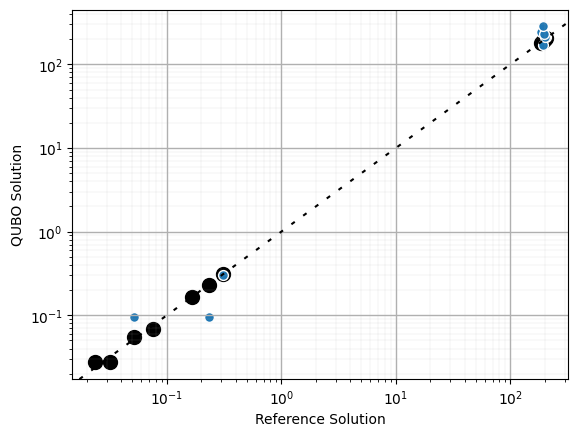

In [41]:
import matplotlib.pyplot as plt 
plt.scatter(ref_values[:-1], encoded_ref_sol, c='black', s=100, label='Best solution')
for s in solutions[2:3]:
    plt.scatter(ref_values[:-1], s, s=50, lw=1, edgecolors='w', label='Sampled solution')
plt.axline((0, 0.0), slope=1, color="black", linestyle=(0, (2, 5)))
plt.axline((0, 0.0), slope=1.05, color="grey", linestyle=(0, (2, 2)))
plt.axline((0, 0.0), slope=0.95, color="grey", linestyle=(0, (2, 2)))
plt.grid(which="major", lw=1)
plt.grid(which="minor", lw=0.1)
plt.xlabel('Reference Solution')
plt.ylabel('QUBO Solution')
# plt.legend()
# plt.xlim([0.01,0.1])
# plt.ylim([0.01,0.1])
plt.loglog()

In [81]:
net.qubo.verify_quadratic_constraints(net.sampleset)

In [ ]:
net.qubo.qubo_dict.num_variables

In [ ]:
import dwave_networkx as dnx
from minorminer import find_embedding
from dwave.embedding import embed_qubo, majority_vote, chain_break_frequency

net.qubo.qubo_dict.to_qubo()[0]

target_graph = dnx.pegasus_graph(6)
embedding = find_embedding(net.qubo.qubo_dict.to_qubo()[0], target_graph)

In [ ]:
dnx.draw_pegasus(target_graph,  node_size=2, width=0.1)

In [ ]:
dnx.draw_pegasus_embedding(target_graph, embedding, node_size=10, width=0.25)